# Postcode Pricing - Phase Alt-net experiment 

https://virginmediao2.atlassian.net/browse/CS-2670

26 Septmber to 5 November (according to campaign roadmap)

In [1]:
import numpy as np
import pandas as pd
from google.cloud import bigquery

import seaborn as sns 
import matplotlib.pyplot as plt 

In [2]:
%load_ext google.cloud.bigquery
project_id ='prj-vo-aa-p-data-science-exp'

# Parameters

In [3]:
# these are the start / end dates from the campaign roadmap
params = {
    'start_date': '2023-09-26',
    'end_date': '2023-11-05'
}

# Plot setup

In [4]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(16,6),
    titlesize=12,
    titleweight="bold",
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize=12,
    titleweight="bold",
    titlesize=12,
    titlepad=10,
)

plt.rc(
    "legend",
    fontsize=12
)

plot_params = dict(
    color="0.75",
    style="._",
    markeredgecolor="0.25",
    marketfacecolor="0.25",
    legend=True
)

# Data

### Sales by postcode by day, along with the treatment group the postcode was assigned to

It would be useful to identify different contract lengths, but we don't have this data until 26 October 2023.

In [5]:
%%bigquery purchases --project $project_id --params $params

WITH
treatment_groups AS (

    SELECT
        postcode,
        treatment,
        overbuild,
        main_competitor_overbuild,
        alt_net_overbuild, -- this is what the experiment was based on

    FROM `prj-vo-aa-p-data-science-exp.m7914180.cs-2670-postcode-pricing-group-allocations`

),

purchases AS (

    -- calling this 'purchases' because it is unclear if it is orders or sales
    SELECT 
        event_date,
        session_key,
        premise_event_parameters.premise_uid,
        user_pseudo_id,
        icoms_account_uid,
        is_order,
        i.item_name, 
        i.item_name_unbundled,
        i.item_brand,
        i.item_category,
        i.item_category2,
        i.item_category3,
        i.price,
        i.item_revenue,
        i.tld_price,
        i.contract_length -- valuea missing until 26 October 2023

    FROM 
        `prj-vo-aa-p-dp-analytics-uat.digital_product_ga4.ga4__events`,
        UNNEST(items) i

    WHERE event_date BETWEEN @start_date AND @end_date
    AND event_name = 'purchase'
    AND item_brand = 'cable'
    
),

postcodes AS (

    SELECT DISTINCT
        icoms_id.icoms_premises_uid,
        premises_location.postcode,
    FROM
        `prj-vo-aa-p-data-modellin-prod.data_modelling_base.premises_details_base` 

)

SELECT
  prch.*,
  pc.postcode,
  grp.*
    
FROM purchases prch

  LEFT JOIN postcodes pc
  ON prch.premise_uid = pc.icoms_premises_uid

  LEFT JOIN treatment_groups grp
  ON pc.postcode = grp.postcode

WHERE icoms_account_uid IS NULL -- new customers?



/Users/jonathan.martin/PythonProjects/postcode_pricing/venv/lib/python3.9/site-packages/google/cloud/bigquery/job/query.py:1687: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/Users/jonathan.martin/PythonProjects/postcode_pricing/venv/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2007: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


In [6]:
purchases = purchases.astype({
    'event_date': 'datetime64[ns]'
})

purchases.shape

(75121, 22)

In [7]:
purchases.head()

event_date               session_key  premise_uid         user_pseudo_id  \
0 2023-11-03  ki0A6/fDLIhbuuVpmQUbzQ==    308352284  1283092871.1699004459   
1 2023-11-03  Wck1VZZdqQQ3kejLbrR0fA==    120185921  2003988374.1686847190   
2 2023-11-03  d9jBwtbENxrnEJwBEsBzQQ==    142953158   490786423.1697324462   
3 2023-11-03                      None    227583605                   None   
4 2023-11-03  6vtAEmwqkjuaSy+Z1Sufug==    206917460  1743501615.1699036972   

   icoms_account_uid  is_order                     item_name  \
0               <NA>         1     volt m250 fibre broadband   
1               <NA>         1          gig1 fibre broadband   
2               <NA>         1  bigger combo bundle + sports   
3               <NA>         1          m125 fibre broadband   
4               <NA>         1        m125 broadband + phone   

              item_name_unbundled item_brand item_category  ...  price  \
0     [volt m250 fibre broadband]      cable         cable  ...  31.99   
1          [gig1 fibre broadband]      cable         cable  ...  50.00   
2  [bigger combo bundle + sports]      cable         cable  ...  65.00   
3          [m125 fibre broadband]      cable         cable  ...  26.50   
4        [m125 broadband + phone]      cable         cable  ...  34.00   

  item_revenue  tld_price  contract_length  postcode  postcode_1 treatment  \
0        31.99        0.0               18  TS10 5AA        None      None   
1        50.00       30.0               24   B31 3JX        None      None   
2        65.00        0.0               18   HX3 8UH        None      None   
3        26.50        0.0               18  LS12 1NH        None      None   
4        34.00        0.0               18  BN14 7AA        None      None   

  overbuild main_competitor_overbuild  alt_net_overbuild  
0      <NA>                      <NA>               <NA>  
1      <NA>                      <NA>               <NA>  
2      <NA>                      <NA>               <NA>  
3      <NA>                      <NA>               <NA>  
4      <NA>                      <NA>               <NA>  

[5 rows x 22 columns]

# Bundle ID to item name lookup

Is this recorded anywhere, or do I have to guess based on prices?

In [8]:
purchases.groupby(['treatment', 'item_name', 'contract_length']).agg(mean_price = ('price', 'mean'))

mean_price
treatment item_name                         contract_length            
control4  big bundle                        18                32.057416
          big volt bundle                   18                38.918571
          bigger combo bundle               18                39.714286
          bigger combo bundle + movies      18                62.000000
          bigger combo bundle + sports      18                69.200000
...                                                                 ...
variant4  volt m350 fibre broadband         18                37.745000
                                            24                33.000000
          volt m350 fibre broadband + phone 18                37.990000
          volt m350 fibre broadband + tv    18               107.000000
          volt m500 fibre broadband + phone 18                48.990000

[87 rows x 1 columns]

In [9]:
purchases.item_name.value_counts().index.to_list()

['m250 fibre broadband',
 'm125 fibre broadband',
 'gig1 fibre broadband',
 'big bundle',
 'm125 broadband + phone',
 'bigger combo bundle',
 'm350 fibre broadband',
 'volt m250 fibre broadband',
 'm500 fibre broadband',
 'fibre broadband volt',
 'mega volt bundle',
 'bigger combo bundle + sports',
 'big volt bundle',
 'bigger combo volt bundle',
 'volt m350 fibre broadband',
 'fibre broadband + home phone volt',
 'volt m250 fibre broadband + phone',
 'm250 broadband + phone',
 'volt gig1 fibre broadband',
 'bigger combo bundle + movies',
 'm50 broadband + phone',
 'volt m1000 fibre broadband + phone',
 'volt m500 fibre broadband',
 'bigger combo volt bundle + sports',
 'm50 fibre broadband',
 'm125 broadband + tv',
 'volt m350 fibre broadband + phone',
 'bigger combo volt bundle + movies',
 'volt m500 fibre broadband + phone',
 'm350 broadband + tv',
 'm500 broadband + phone',
 'biggest combo bundle',
 'm1000 broadband + phone',
 'm350 broadband + phone',
 'm250 broadband + tv',
 'big

In [10]:
# guesses

bundle_id_lookup = {

    9310: '...',
    9309: '...',
    9311: '...',
    9312: '...',
    9313: '...',
    4301: '...',
    4300: '...',
    4304: '...',
    4302: '...',
    4305: '...',
    4019: '...',
    4020: '...',
    4021: '...',
    4015: '...',
    4016: '...',
    4017: '...'

}

# Aggregates

Do various convenient aggregates up front here

In [12]:
daily_sales = (purchases[~purchases.treatment.isna()]
               .groupby(['treatment', 'item_name', 'event_date'])
               .size()
               .reset_index(name='num_sales')
               .pivot(
                   index='event_date',
                   columns=['treatment', 'item_name'],
                   values='num_sales'
                )
                .sort_index()
                )

daily_sales.head()

treatment    control4                                      \
item_name  big bundle big volt bundle bigger combo bundle   
event_date                                                  
2023-09-26        9.0             NaN                 5.0   
2023-09-27        9.0             4.0                 5.0   
2023-09-28        8.0             1.0                 2.0   
2023-09-29        9.0             1.0                 2.0   
2023-09-30        5.0             NaN                 1.0   

treatment                                                             \
item_name  bigger combo bundle + movies bigger combo bundle + sports   
event_date                                                             
2023-09-26                          NaN                          1.0   
2023-09-27                          NaN                          4.0   
2023-09-28                          1.0                          1.0   
2023-09-29                          1.0                          NaN   
2023-09-30                          NaN                          1.0   

treatment                                                              \
item_name  bigger combo volt bundle bigger combo volt bundle + movies   
event_date                                                              
2023-09-26                      NaN                               NaN   
2023-09-27                      NaN                               NaN   
2023-09-28                      3.0                               NaN   
2023-09-29                      1.0                               NaN   
2023-09-30                      NaN                               1.0   

treatment                                                          \
item_name  bigger combo volt bundle + sports biggest combo bundle   
event_date                                                          
2023-09-26                               NaN                  NaN   
2023-09-27                               NaN                  NaN   
2023-09-28                               1.0                  NaN   
2023-09-29                               NaN                  NaN   
2023-09-30                               NaN                  NaN   

treatment                             ...         variant4  \
item_name  biggest combo volt bundle  ... mega volt bundle   
event_date                            ...                    
2023-09-26                       NaN  ...              1.0   
2023-09-27                       NaN  ...              NaN   
2023-09-28                       NaN  ...              5.0   
2023-09-29                       NaN  ...              1.0   
2023-09-30                       NaN  ...              2.0   

treatment                                                                \
item_name  volt gig1 fibre broadband volt m1000 fibre broadband + phone   
event_date                                                                
2023-09-26                       NaN                                NaN   
2023-09-27                       NaN                                NaN   
2023-09-28                       NaN                                NaN   
2023-09-29                       NaN                                NaN   
2023-09-30                       NaN                                NaN   

treatment                                                               \
item_name  volt m250 fibre broadband volt m250 fibre broadband + phone   
event_date                                                               
2023-09-26                       1.0                               NaN   
2023-09-27                       3.0                               NaN   
2023-09-28                       4.0                               NaN   
2023-09-29                       5.0                               1.0   
2023-09-30                       5.0                               NaN   

treatment                                                               \
item_name  volt m350 fibre broa

In [13]:
overall_price_variation = (purchases[~purchases.treatment.isna()]
                           .groupby(['treatment', 'item_name'])
                           .agg(
                                min_price = ('price', 'min'),
                                max_price = ('price', 'max'),
                                mean_price = ('price', 'mean'),
                            )
                            .reset_index()
                            .pivot(
                                index='item_name',
                                columns='treatment', 
                                values=['min_price', 'max_price', 'mean_price']
                            )
                            .sort_index()
                            )
overall_price_variation.head()

min_price          max_price          mean_price  \
treatment                     control4 variant4  control4 variant4   control4   
item_name                                                                       
big bundle                       31.99    30.99     56.99    49.99  32.338378   
big volt bundle                  31.99    31.99     51.99    57.99  37.228095   
bigger combo bundle              39.50    38.50     45.50    57.50  40.035714   
bigger combo bundle + movies     62.00    62.00     68.00    74.00  62.923077   
bigger combo bundle + sports     65.00    65.00     83.00    83.00  66.607143   

                                         
treatment                      variant4  
item_name                                
big bundle                    31.390672  
big volt bundle               38.528462  
bigger combo bundle           39.417355  
bigger combo bundle + movies  65.333333  
bigger combo bundle + sports  65.705882

In [14]:
daily_price_variation = (purchases[~purchases.treatment.isna()]
                           .groupby(['treatment', 'item_name', 'event_date'])
                           .agg(
                                min_price = ('price', 'min'),
                                max_price = ('price', 'max'),
                                mean_price = ('price', 'mean'),
                            )
                            .reset_index()
                            .pivot(
                                index='event_date',
                                columns=['item_name', 'treatment'], 
                                values=['min_price', 'max_price', 'mean_price']
                            )
                            .sort_index()
                            )

daily_price_variation.head()


min_price                                      \
item_name  big bundle big volt bundle bigger combo bundle   
treatment    control4        control4            control4   
event_date                                                  
2023-09-26      31.99             NaN                39.5   
2023-09-27      31.99           31.99                39.5   
2023-09-28      31.99           43.99                39.5   
2023-09-29      31.99           31.99                39.5   
2023-09-30      31.99             NaN                39.5   

                                                                      \
item_name  bigger combo bundle + movies bigger combo bundle + sports   
treatment                      control4                     control4   
event_date                                                             
2023-09-26                          NaN                         65.0   
2023-09-27                          NaN                         65.0   
2023-09-28                         68.0                         65.0   
2023-09-29                         62.0                          NaN   
2023-09-30                          NaN                         65.0   

                                                                       \
item_name  bigger combo volt bundle bigger combo volt bundle + movies   
treatment                  control4                          control4   
event_date                                                              
2023-09-26                      NaN                               NaN   
2023-09-27                      NaN                               NaN   
2023-09-28                    49.99                               NaN   
2023-09-29                    60.99                               NaN   
2023-09-30                      NaN                              68.0   

                                                                   \
item_name  bigger combo volt bundle + sports biggest combo bundle   
treatment                           control4             control4   
event_date                                                          
2023-09-26                               NaN                  NaN   
2023-09-27                               NaN                  NaN   
2023-09-28                              65.0                  NaN   
2023-09-29                               NaN                  NaN   
2023-09-30                               NaN                  NaN   

                                      ...       mean_price  \
item_name  biggest combo volt bundle  ... mega volt bundle   
treatment                   control4  ...         variant4   
event_date                            ...                    
2023-09-26                       NaN  ...             85.0   
2023-09-27                       NaN  ...              NaN   
2023-09-28                       NaN  ...             88.6   
2023-09-29                       NaN  ...             85.0   
2023-09-30                       NaN  ...             85.0   

                                                                         \
item_name  volt gig1 fibre broadband volt m1000 fibre broadband + phone   
treatment                   variant4                           variant4   
event_date                                                                
2023-09-26                       NaN                                NaN   
2023-09-27                       NaN                                NaN   
2023-09-28                       NaN                                NaN   
2023-09-29                       NaN                                NaN   
2023-09-30                       NaN                                NaN   

                                                                        \
item_name  volt m250 fibre broadband volt m250 fibre broadband + phone   
treatment                   variant4                          variant4   
event_date                                                               
20

# Sense checking

In [15]:
purchases.groupby('treatment').agg(num_postcodes = ('postcode', 'nunique'))

num_postcodes
treatment               
control4            3825
variant4            3937

In [16]:
purchases.query("item_name == 'm125 fibre broadband'").treatment.value_counts(normalize=True)

variant4    0.523519
control4    0.476481
Name: treatment, dtype: float64

# Questions

In [17]:
# Are prices being recorded correctly now? I heard there was an issue, but no details or updates

In [18]:
# we don't have contract length before mid-October?

In [19]:
# how was traffic actually split?

In [20]:
# how do we identify affiliates in GA4?
...

### Inspect the overall pattern of sales -- anything odd?

<AxesSubplot: xlabel='event_date'>

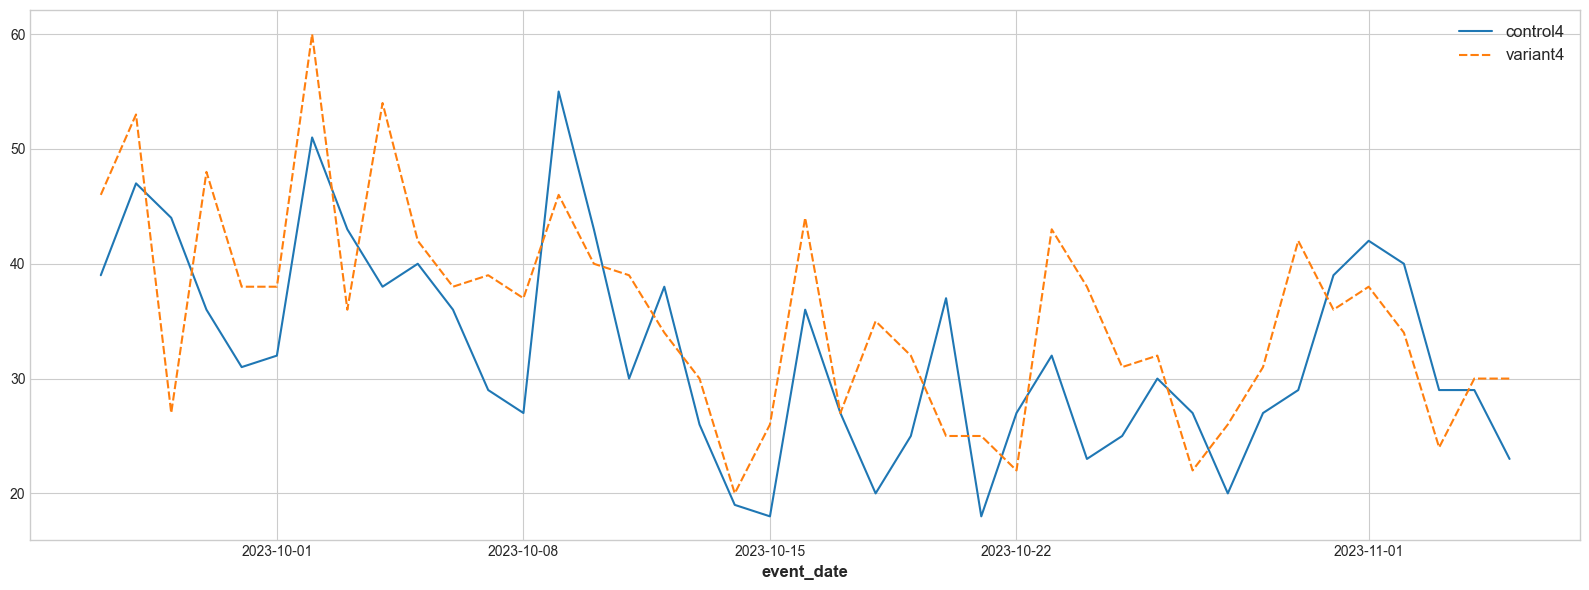

In [21]:
selected_item_name = 'm125 fibre broadband'

idx = pd.IndexSlice
sns.lineplot(data=daily_sales.loc(1)[:,idx[selected_item_name]])

### were prices consistently applied to the treatment and control products?



In [22]:
# average prices across treatments are quite similar?
selected_item_name = 'm125 fibre broadband'

overall_price_variation.query('item_name == @selected_item_name')

min_price          max_price          mean_price  \
treatment             control4 variant4  control4 variant4   control4   
item_name                                                               
m125 fibre broadband      26.5     25.5      49.0     49.0  26.813361   

                                 
treatment              variant4  
item_name                        
m125 fibre broadband  26.487771

/var/folders/pq/1pygt1_j2fn4w2qq_zh70bdh0000gp/T/ipykernel_17819/1893023315.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.lineplot(data=daily_price_variation.loc(1)[idx['mean_price'], idx[selected_item_name]])


Text(0.5, 1.0, 'Daily mean price of m125 fibre broadband between 2023-09-26 and 2023-11-05')

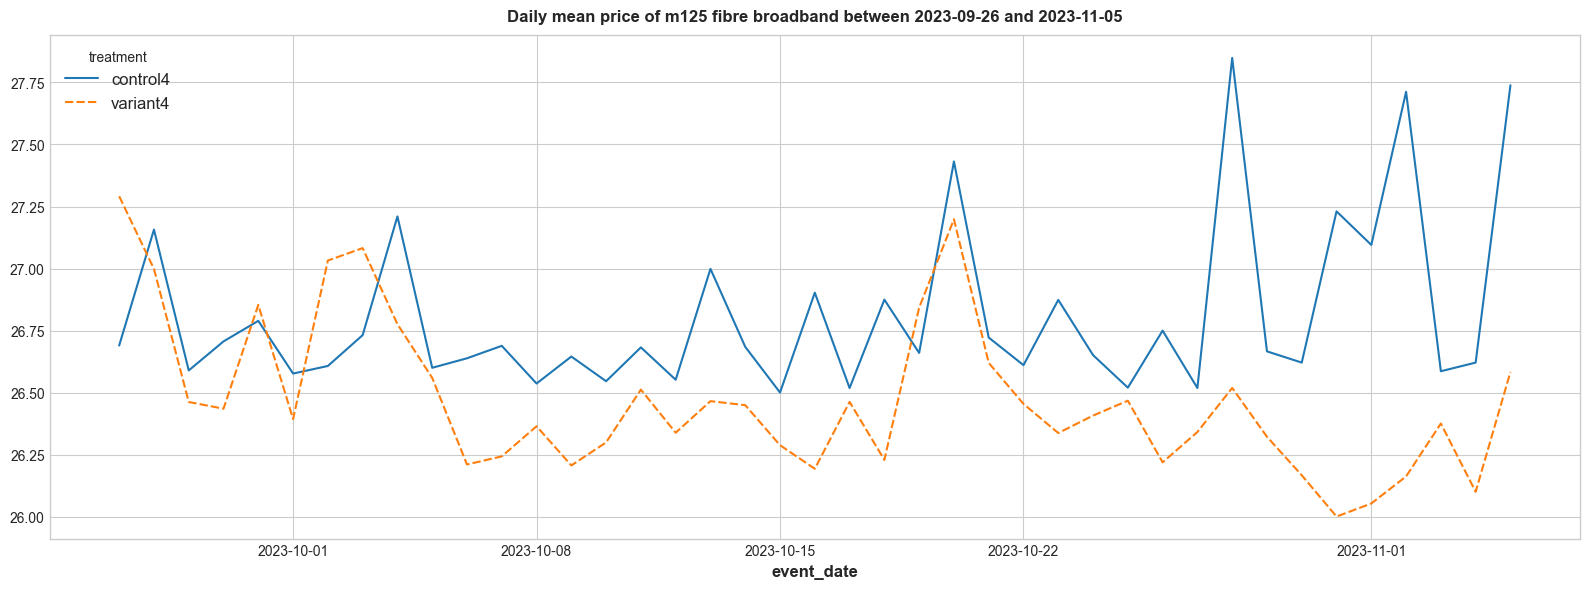

In [24]:
# sns.lineplot(data=daily_prices_by_treatment.query('item_name == @selected_item_name'), x='event_date', y='price', hue='treatment', errorbar=('ci', True))
# plt.title(f"Daily prices for {selected_item_name} between {params['start_date']} and {params['end_date']}")

selected_item_name = 'm125 fibre broadband'

idx = pd.IndexSlice
sns.lineplot(data=daily_price_variation.loc(1)[idx['mean_price'], idx[selected_item_name]])

plt.title(f"Daily mean price of {selected_item_name} between {params['start_date']} and {params['end_date']}")


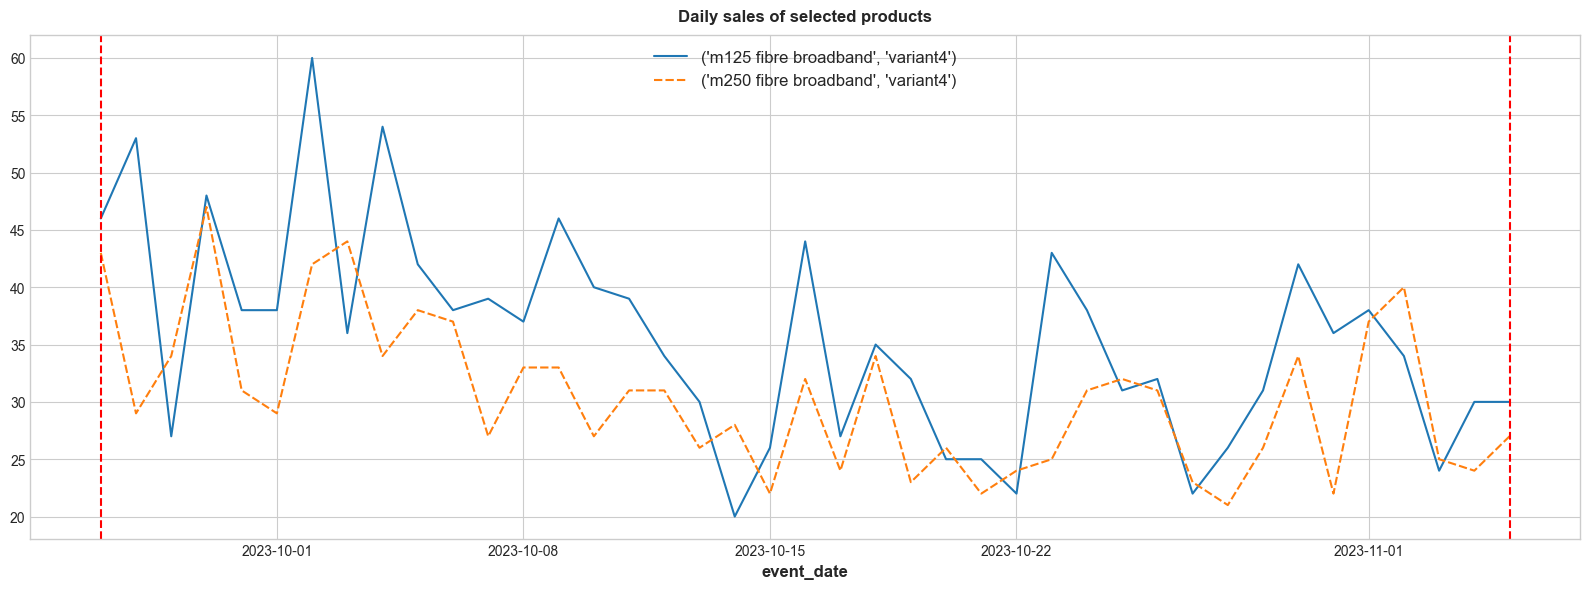

In [28]:
selected_items = ["m125 fibre broadband", "m250 fibre broadband"]
selected_treatments = ['variant4']  

plot_data = (purchases
             .query('treatment in @selected_treatments')
             .query('item_name in @selected_items')
             .groupby(['event_date', 'item_name', 'treatment']).size().reset_index(name='num_sales')
             .pivot(index='event_date', columns=['item_name', 'treatment'], values='num_sales')
             )
             
plot_data.columns = plot_data.columns.to_flat_index()

sns.lineplot(data=plot_data)

plt.title("Daily sales of selected products")

plt.axvline(pd.Timestamp(params['start_date']), linestyle='dashed', color='red')
plt.axvline(pd.Timestamp(params['end_date']), linestyle='dashed', color='red')

In [29]:
# were there cheaper options available for certain products?
selected_item_names = ["m125 fibre broadband", "m250 fibre broadband"]

(purchases
.query('item_name in @selected_item_names')
.groupby(['event_date', 'item_name', 'treatment'])
.agg(
    min_price = ('price', 'min'),
    max_price = ('price', 'max')
)
.reset_index()
.pivot(
    index=['event_date','treatment'],
    columns='item_name',
    values=['min_price', 'max_price']
)
)

min_price                       \
item_name            m125 fibre broadband m250 fibre broadband   
event_date treatment                                             
2023-09-26 control4                  26.5                 30.5   
           variant4                  26.5                 30.5   
2023-09-27 control4                  26.5                 30.5   
           variant4                  26.5                 30.5   
2023-09-28 control4                  26.5                 30.5   
...                                   ...                  ...   
2023-11-03 variant4                  25.5                 30.5   
2023-11-04 control4                  26.5                 30.5   
           variant4                  25.5                 30.5   
2023-11-05 control4                  26.5                 30.5   
           variant4                  26.5                 30.5   

                                max_price                       
item_name            m125 fibre broadband m250 fibre broadband  
event_date treatment                                            
2023-09-26 control4                 28.99                 55.0  
           variant4                 49.00                 55.0  
2023-09-27 control4                 49.00                 33.0  
           variant4                 49.00                 33.0  
2023-09-28 control4                 26.99                 55.0  
...                                   ...                  ...  
2023-11-03 variant4                 29.00                 55.0  
2023-11-04 control4                 30.00                 33.0  
           variant4                 26.50                 32.0  
2023-11-05 control4                 49.00                 33.0  
           variant4                 28.99                 33.0  

[82 rows x 4 columns]